# Finning Tuning Wav2Vec2 para IMDB

# Instalações, Imports, Device e Download

In [ ]:
%%capture
!pip install -q install transformers pytorch_lightning neptune-client==0.9.8

In [ ]:
from collections import Counter
import random

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
import torchmetrics

from transformers import AutoTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2ForSequenceClassification
from transformers import Wav2Vec2Model
from transformers import BertModel

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

import neptune.new as neptune

pl.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   print(torch. cuda. get_device_name(dev))
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

Tesla K80
cuda:0


In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

--2021-12-02 20:19:04--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.2.19, 172.67.69.159, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.2.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/aclImdb.tgz [following]
--2021-12-02 20:19:04--  https://files.fast.ai/data/aclImdb.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.2.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  10.2MB/s    in 15s     

2021-12-02 20:19:20 (9.52 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



# Preparing Data

In [ ]:
import os

max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
False I have seen many, many productions of The Nutcracker. Now perhaps I viewed this movie from the taint
False Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Care
True If you r in mood for fun...and want to just relax and enjoy...bade Miyan Chote Miyan is one of the m
3 últimas amostras treino:
False I went to see this film with low expectations, but hoping to be charmed by seeing my home town on fi
True I don't watch a lot of TV, except for The Office, Weeds, Entourage and E!'s Soup. I think I hold thi
True Alright, I have to admit that I have never seen "Rhoda" and only one or two episodes of "The Mary Ty
3 primeiras amostras validação:
True This is one of those movies that you wish you hadn't seen before - so you could see it again " for t
True Granted I had seen some "Speed Racer", but I never really watched it and I ha

# Visualising BERT Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
encoded_input = tokenizer("Hello, I'm a single sentence!")
print(encoded_input)
print("Deconding sentence: ", tokenizer.decode(encoded_input["input_ids"]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': [0, 9528, 2029, 4, 1622, 51899, 599, 1517, 15330, 1302, 6502, 1883, 7360, 381, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Deconding sentence:  <s> Hello, I'm a single sentence! </s>


In [ ]:
# Exemplo com batch
batch_sentences = ["Hello I'm a single sentence",
                    "And another sentence",
                    "And the very very last one"]
# o comando padding='max_length', nãão irá truncar o texto, porém, irá adaptar o pad no maior tamanho de sentença que houver na base
# Não sóó no batch
encoded_inputs = tokenizer(batch_sentences, padding='max_length')

print('batch size: ', len(encoded_inputs["input_ids"]))
print(encoded_inputs)

batch size:  3
{'input_ids': [[0, 29048, 1622, 51899, 599, 1517, 15330, 1302, 6502, 11851, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 3204, 2158, 7001, 13722, 1302, 6502, 11851, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Dataset and Dataloader

In [ ]:
class IMDBDataset(torch.utils.data.Dataset):   
    def __init__(self, sentences, labels, max_length, model_tokens, normalize):
        super().__init__()

        self.tokenizer = AutoTokenizer.from_pretrained(model_tokens)
        self.tokens = self.tokenizer(sentences, padding = "max_length", max_length = max_length, truncation=True)["input_ids"]
        self.mask_attention = self.tokenizer(sentences, padding = "max_length", max_length = max_length, truncation=True)["attention_mask"]
        self.labels = labels
        self.normalize = normalize
        self.norm_amplitude = 1
        self.train_mean = 2043.0015869140625
        self.train_std = 3944.133544921875

    def __len__(self):
        return len(self.labels)
         
    def __getitem__(self, idx):
      inputs = torch.tensor(self.tokens[idx]).float()
      if(self.normalize):
          #inputs = (inputs - self.train_mean)/self.train_std
          
          #v_min, v_max = inputs.min(), inputs.max()
          #new_min, new_max = -self.norm_amplitude, self.norm_amplitude
          #inputs = (inputs - v_min)/(v_max - v_min)*(new_max - new_min) + new_min

          inputs = torch.nn.functional.normalize(inputs, p=2.0, dim=0)
      return inputs,torch.tensor(self.mask_attention[idx]).float(), torch.tensor(self.labels[idx]).long()
    

class IMDBDataModule(pl.LightningDataModule):
    def __init__(self,model_tokens,
                 x_train,y_train, 
                 x_val,y_val, 
                 x_test,y_test,
                 normalize,
                 batch_size: int = 50, 
                 num_workers: int = 2,
                 max_length: int = 200,
                 ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.model_token = model_tokens
        self.max_length = max_length
        self.x_train =  x_train
        self.y_train =  y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.normalize = normalize
        
        
                  
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
          self.train_dataset= IMDBDataset(list(self.x_train), list(self.y_train), self.max_length, model_tokens = self.model_token, normalize = self.normalize)
          self.val_dataset = IMDBDataset(list(self.x_val), list(self.y_val), self.max_length, model_tokens = self.model_token, normalize = self.normalize)

        if stage == 'test' or stage is None:
            self.test_dataset =  IMDBDataset(list(self.x_test), list(self.y_test), self.max_length, model_tokens = self.model_token, normalize = self.normalize)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Model

In [ ]:
class ReviewClassifier(nn.Module):
    def __init__(self,num_class,w2v2_model = 'facebook/wav2vec2-base'):
        super().__init__()      
        self.w2v2_layer = Wav2Vec2ForSequenceClassification.from_pretrained(w2v2_model, num_labels=num_class, conv_stride=[1,1,1,1,1,1,1])  

    def forward(self, seq, attn_masks):
        logits = self.w2v2_layer(input_values=seq).logits
        return logits
    

class LiteModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.params = hparams
        self.best_valid_loss = 10e9
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model = ReviewClassifier(num_class = hparams['n_classes'], w2v2_model = hparams['model'])
    
    def forward(self, x_indexs, x_att_mask):
        logits = self.model(x_indexs, x_att_mask)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x_indexs, x_att_mask, y = train_batch
        logits = self.model(x_indexs, x_att_mask)
        batch_losses = self.criterion(logits.squeeze(-1), y)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        run['train/loss'].log(avg_loss)
        self.log('train_loss', avg_loss, on_epoch=True, prog_bar=True)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x_indexs, x_att_mask, y = val_batch
        logits, preds = self.forward(x_indexs, x_att_mask)
        batch_losses = self.criterion(logits, y)
        batch_accuracy = (preds == y)
        val_f1 = torchmetrics.functional.f1(preds, y, num_classes=2, average='weighted')
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy,
                "batch_f1": val_f1}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()
        f1 = torch.stack([output['batch_f1'] for output in outputs]).float().mean()
        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)
        run['valid/F1'].log(f1)
        metrics = {'valid_loss': avg_loss.item(), 'accuracy': accuracy.item(), 'f1-score':f1.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}
      
        if avg_loss < self.best_valid_loss:
            torch.save(self.model.state_dict(), '/content/'+'wav2vec2-base'+'best_model.pt')
            self.best_valid_loss = avg_loss
        torch.save(self.model.state_dict(), '/content/'+'wav2vec2-base'+'trainer_model.pt')
        
        self.log('validate_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('validate_acc', accuracy, on_epoch=True, prog_bar=True)
        self.log('validate_f1', f1, on_epoch=True, prog_bar=True)
        return output
  
    def test_step(self, val_batch, batch_idx):
        x_indexs, x_att_mask, y = val_batch
        logits, preds = self.forward(x_indexs, x_att_mask)
        batch_losses = self.criterion(logits, y)
        batch_accuracy = (preds == y)
        test_f1 = torchmetrics.functional.f1(preds, y, num_classes=2, average='weighted')
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy,
                'batch_f1':test_f1}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()
        f1 = torch.stack([output['batch_f1'] for output in outputs]).float().mean()
        metrics = {'Test loss': avg_loss.item(), 'test accuracy': accuracy.item(), 'test f1':f1.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy,  on_epoch=True, prog_bar=True)
        self.log('test_f1', f1,  on_epoch=True, prog_bar=True)
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adamax(self.model.parameters(), lr=self.params['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

# Experiment

In [ ]:
run = neptune.init(
    project="leonardoboulitreau/W2V2-IMDB",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwZDM3MTQ4NC1kMzMxLTRjYjEtYmFlMy1iNGI2NmIxOWNhOGMifQ==",
) 

https://app.neptune.ai/leonardoboulitreau/W2V2-IMDB/e/WVIM-26


In [ ]:
# definindo os hyperparametros
hparams = {
    'max_epochs': 15,
    'max_length': 512,
    'n_classes':2,
    'model':'facebook/wav2vec2-base-960h',
    'learning_rate': 1e-4,
    'bs':10
}

#init 
dm = IMDBDataModule(batch_size=hparams['bs'],x_train = x_train, y_train = y_train,
                    x_val=x_valid, y_val = y_valid, 
                    x_test= x_test, y_test = y_test,
                    normalize = True,
                    model_tokens = 'bert-base-uncased',
                    max_length = hparams['max_length'],
                    )

# To access the x_dataloader we need to call prepare_data and setup.
dm.setup()

#init model
pl_model = LiteModel(hparams=hparams)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=hparams['max_epochs'],
                     progress_bar_refresh_rate=1,
                     accumulate_grad_batches = 2,
                     gpus=1,
                     log_every_n_steps=1) 
              
# Train the model
%time trainer.fit(pl_model, dm)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.bias', 'projector.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be 

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 123
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'batch_losses'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 5h 25min 23s, sys: 2min 20s, total: 5h 27min 43s
Wall time: 5h 21min 32s


In [ ]:
#teste
#%time trainer.test(test_dataloaders=dm.test_dataloader())

# Destrinchando o Modelo

In [ ]:
test_model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=2, conv_stride=[1,1,1,1,1,1,1], output_hidden_states=True)
test_model

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:341: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.weight', 'project_q.bias', 'quantizer.codevectors', 'project_hid.weight', 'project_hid.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertFor

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(1,), bias=False)
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), bias=False)
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), bias=False)
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), bias=False)
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), bias=False)
        )
        (5): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(1,), bias=False)
        )
 

In [ ]:
# Instanciação DataLoader
train_dataset= IMDBDataset(list(x_train), list(y_train), 512, model_tokens = 'bert-base-uncased', normalize=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
print(batch)

[tensor([[0.0012, 0.0242, 0.0293,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0104, 0.0205,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0199, 0.0201,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0007, 0.0229, 0.0571,  ..., 0.0144, 0.0065, 0.0007],
        [0.0008, 0.0165, 0.0252,  ..., 0.0000, 0.0000, 0.0000],
        [0.0015, 0.0327, 0.2113,  ..., 0.0000, 0.0000, 0.0000]]), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0])]


In [ ]:
z = test_model(input_values = batch[0])
print(z.logits)
print(z.logits.argmax(dim=1))

tensor([[ 0.0187,  0.0599],
        [ 0.0378,  0.0639],
        [ 0.0169,  0.0624],
        [ 0.0106,  0.0931],
        [ 0.0055,  0.0496],
        [ 0.0505,  0.0733],
        [ 0.0271,  0.0667],
        [ 0.0335,  0.0743],
        [ 0.0457,  0.0711],
        [-0.0227,  0.0825]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


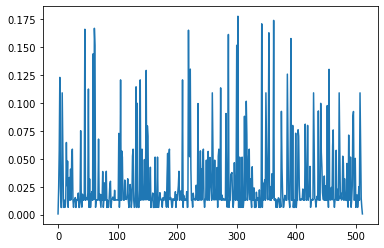

In [ ]:
import matplotlib.pyplot as plt
plt.plot(batch[0][7])